<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_deepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Libs

In [2]:
import keras
from keras.layers import *
from keras.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

Using TensorFlow backend.


# Load Data

In [3]:
data = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
features = list(np.load(data_path + 'features.pkl.npy'))
print('data shape: ', data.shape)
print('features lenght: ', len(features))

data shape:  (48813, 39)
features lenght:  31


In [0]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

# Model definition

In [0]:
from keras.layers.merge import concatenate

In [6]:
cat_features = ['workclass', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country',
       'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country']

input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in cat_features:
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(X.shape[1] - len(cat_features),))
embedding_numeric = Dense(64)(input_numeric) 

input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)

output = Dense(128, kernel_initializer = "uniform")(output)
output = Activation('relu')(output)

layers_num = 1
neurons_num = 64
for layer in range(layers_num):
  output = Dense(neurons_num, kernel_initializer = "uniform")(output)
  output = Activation('relu')(output)
  #output= Dropout(0.3)(output)

layers_num = 1
neurons_num = 32
for layer in range(layers_num):
  output = Dense(neurons_num, kernel_initializer = "uniform")(output)
  output = Activation('relu')(output)
  #output= Dropout(0.2)(output)


output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)

optimizer = keras.optimizers.Adam()
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy']
)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model Training




Train on 32704 samples, validate on 16109 samples
Epoch 1/1024





32704/32704 [==============================] - 20s 599us/step - loss: 0.3359 - acc: 0.8451 - val_loss: 0.3169 - val_acc: 0.8575
Epoch 2/1024
32704/32704 [==============================] - 14s 423us/step - loss: 0.3123 - acc: 0.8555 - val_loss: 0.3125 - val_acc: 0.8574
Epoch 3/1024
32704/32704 [==============================] - 14s 415us/step - loss: 0.3080 - acc: 0.8563 - val_loss: 0.3102 - val_acc: 0.8570
Epoch 4/1024
32704/32704 [==============================] - 13s 412us/step - loss: 0.3054 - acc: 0.8574 - val_loss: 0.3101 - val_acc: 0.8604
Epoch 5/1024
32704/32704 [==============================] - 13s 409us/step - loss: 0.3027 - acc: 0.8588 - val_loss: 0.3115 - val_acc: 0.8585
Epoch 6/1024
32704/32704 [==============================] - 13s 412us/step - loss: 0.3019 - acc: 0.8597 - val_loss: 0.3114 - val_acc: 0.8554
Epoch 7/1024
32704/32704 [==============================] - 14s 422us/step - loss: 0.2996 - acc:

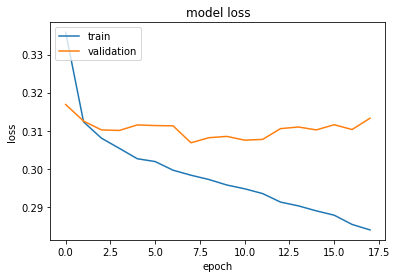

In [7]:
def preproc(X_train, X_test):

    input_list_train = []
    #input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in cat_features:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        #input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in cat_features)]
    input_list_train.append(X_train[other_cols].values)
    #input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train_list, X_test_list = preproc(X_train, X_test)

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train_list, y_train, epochs = 1024, batch_size = 32,
                    validation_data = (X_test_list, y_test), callbacks = [early_stop])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc ='upper left')
plt.show()

# Model evaluation

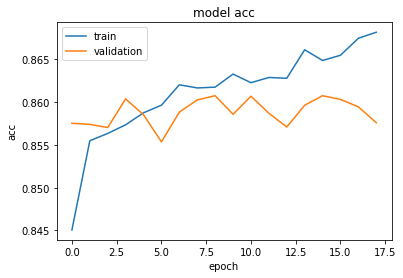

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc ='upper left')
plt.show()

------train-----------
accuracy_score:  0.8708414872798435
f1_score:  0.7083275790636652
roc_auc_score:  0.7980713193300434
------test-------------
accuracy_score:  0.8575951331553789
f1_score:  0.6827986725663716
roc_auc_score:  0.7809807535658215


(array([26002.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6702.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

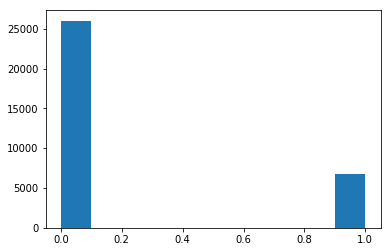

In [9]:
y_train_hat = model.predict(X_train_list).round()
y_test_hat = model.predict(X_test_list).round()

tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)
plt.hist(y_train_hat)

[[11346   858]
 [ 1436  2469]]


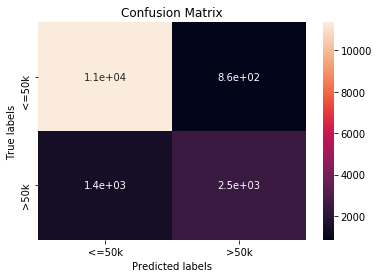

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax =  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12204
           1       0.74      0.63      0.68      3905

    accuracy                           0.86     16109
   macro avg       0.81      0.78      0.80     16109
weighted avg       0.85      0.86      0.85     16109



# Model saving

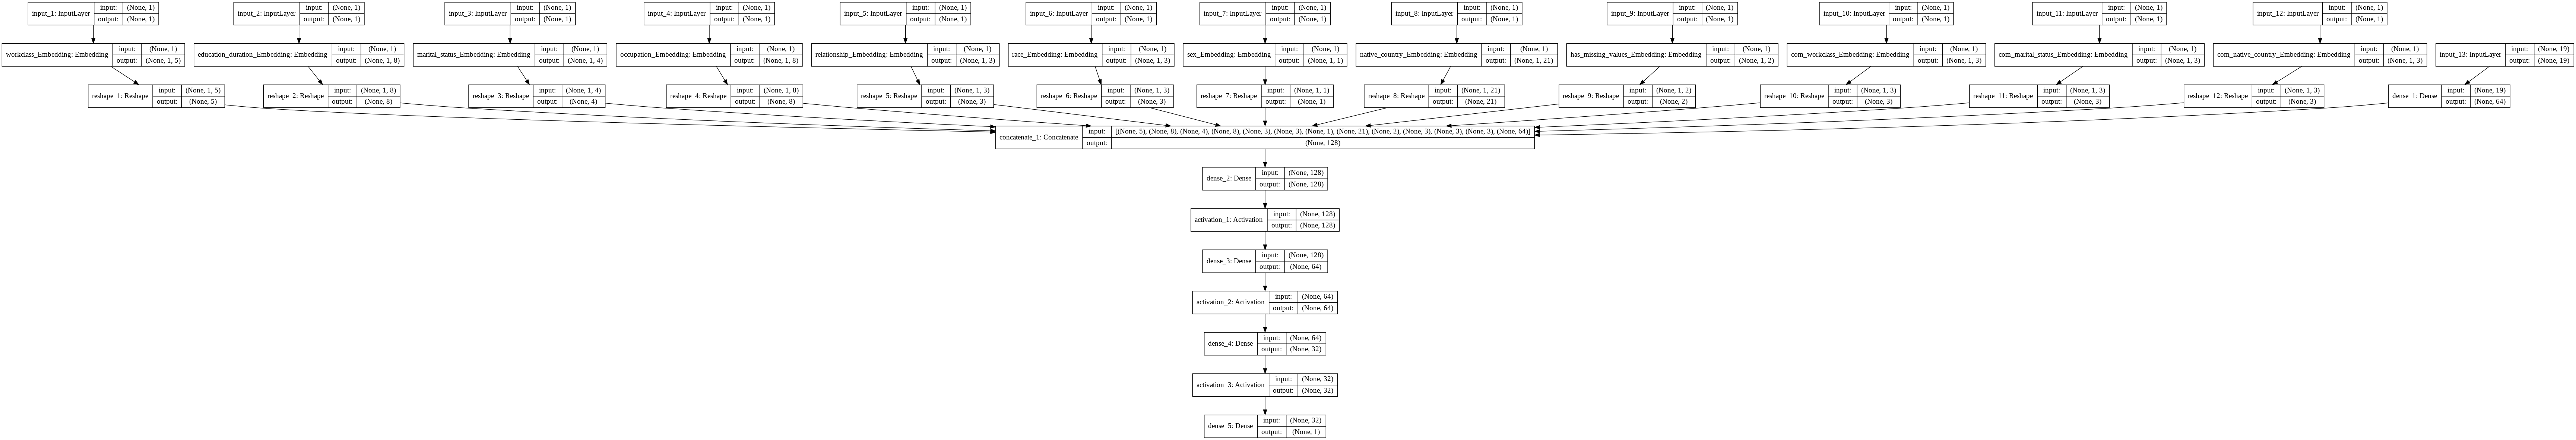

In [10]:
from keras.utils import plot_model
from IPython.display import Image
import pydot_ng as pydot
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           to_file = data_path + 'model.png')
Image(retina = True, filename= data_path + 'model.png')

In [13]:
model.save(model_path + "nn_model_1.h5") 
model_json = model.to_json()
with open(model_path + "nn_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_path + "nn_model.h5")
print("Saved model to cloud")

Saved model to cloud
